In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as sts
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from copy import deepcopy
%matplotlib inline

In [2]:
lines = []
with open('data.gpr','r') as file:
    for line in file:
        lines.append(line.strip())

In [3]:
def analise_Butt(buttResult):
    if  buttResult == "NoButt":
        return 0
    else:
        newButtResult = re.findall(':(.+)', buttResult)[0].lower()
        if newButtResult == 'left':
            return 1
        else:
            return -1

In [4]:
def get_mouse_components(line):
    components = {}
    patterns = ['x:(\d*)\s', 'y:(\d*)\s', 'y:.+?\s(.+?)$']
    components.update({'x':re.findall(patterns[0], line)[0]})
    components.update({'y':re.findall(patterns[1], line)[0]})
    components.update({'click':analise_Butt(re.findall(patterns[2], line)[0])})
    return components

def get_butt_delay(line):
    return int(re.findall(':.*?(\d+)',line)[0])

def get_delay(line):
    time = re.findall('Delay:(.+)',line)[0]
    return datetime.strptime(time, "%H:%M:%S")   

In [5]:
columns = ['butt_delay', 'x', 'y', 'click', 'delay']
df = pd.DataFrame(columns=columns)

In [6]:
df_index = 0
for line_index in range(len(lines) - 2):
    column_meanings = {}
    was_found = 0
    if 'butt' in re.findall('^.+?:', lines[line_index])[0].lower():
        column_meanings.update({'butt_delay': get_butt_delay(lines[line_index])})
        was_found = 1
    if 'mouse' in re.findall('^.+?:', lines[line_index + 1])[0].lower():
        mouse_data = get_mouse_components(lines[line_index + 1])
        column_meanings.update({'mouse_click': mouse_data.get('click')})
        column_meanings.update({'x': mouse_data.get('x')})
        column_meanings.update({'y': mouse_data.get('y')})
        was_found = 1
    if len(re.findall('^.+?:', lines[line_index + 2])) > 0:
        final_line = re.findall('^.+?:', lines[line_index + 2])[0].lower()
        if 'butt' not in final_line and 'delay' in final_line:
            column_meanings.update({'delay': get_delay(lines[line_index + 2])})
        else:
            column_meanings.update({'delay': datetime.strptime('00:00:00', "%H:%M:%S")}) 
    else:
        column_meanings.update({'delay': datetime.strptime('00:00:00', "%H:%M:%S")}) 
    if was_found == 1:
        line_index = line_index + 2
        butt_delay = column_meanings.get('butt_delay')
        click = column_meanings.get('mouse_click')
        x = column_meanings.get('x')
        y = column_meanings.get('y')
        delay = column_meanings.get('delay')
        
        df.loc[df_index] = [butt_delay, x, y, click, delay]
        df_index += 1

### Проанализируем полученные данные

In [32]:
delay_column = df['delay']    
delay_seconds = [delay_column[i].second for i in range(len(delay_column))]
df.fillna(np.mean(df.butt_delay), inplace=True)

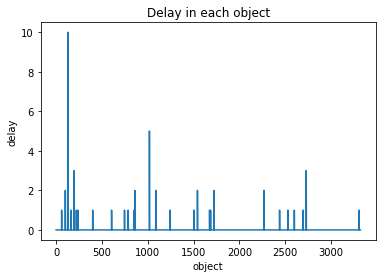

In [33]:
plt.plot(delay_seconds)
plt.title('Delay in each object')
plt.xlabel('object')
plt.ylabel('delay')

([], <a list of 0 Text yticklabel objects>)

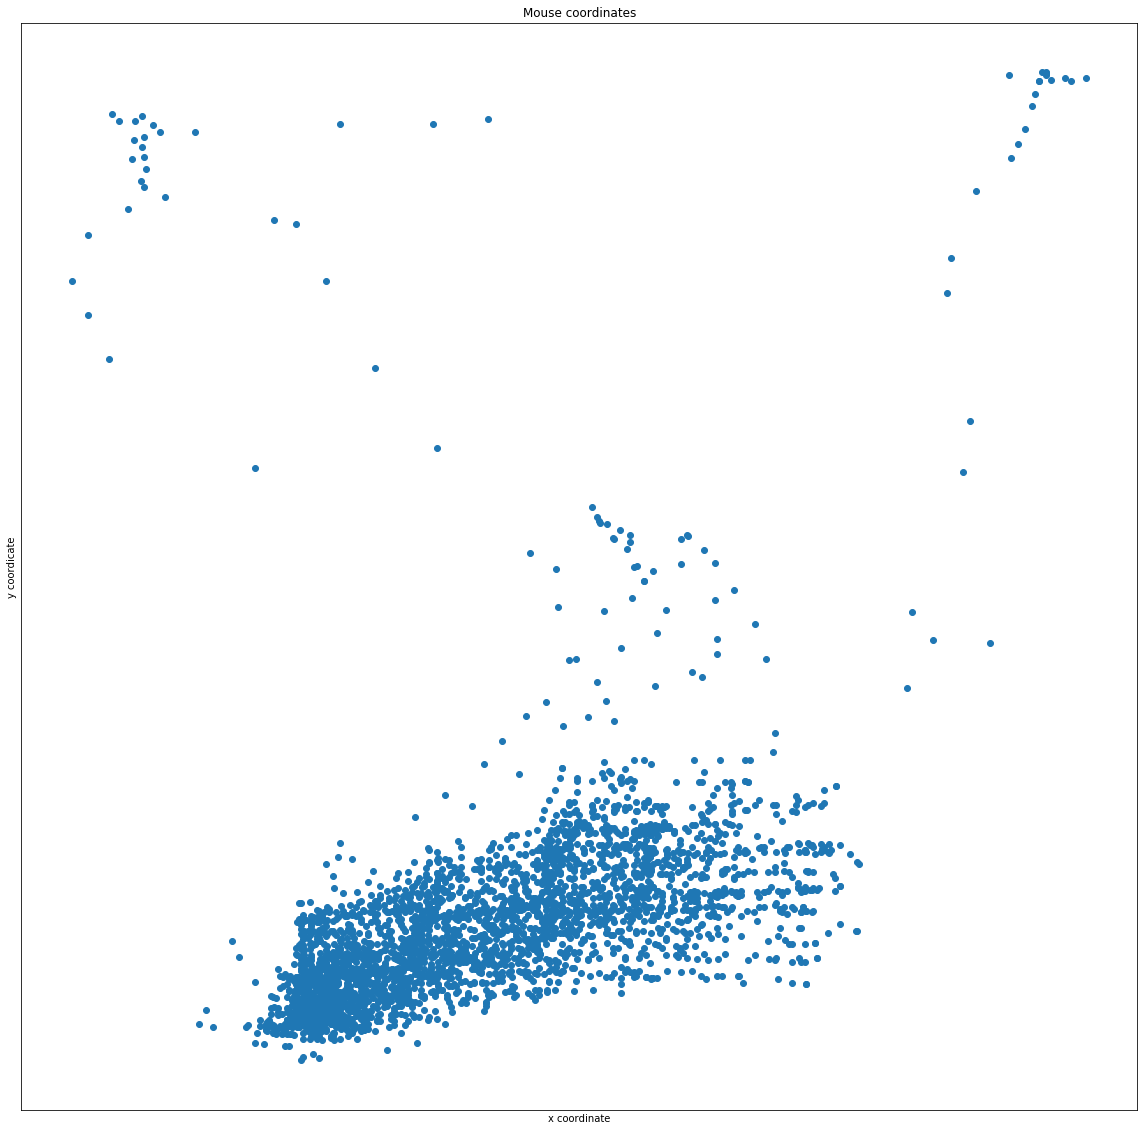

In [34]:
plt.figure(figsize=(20, 20))
plt.scatter(x = df.x, y = df.y)
plt.xlabel('x coordinate')
plt.ylabel('y coordicate')
plt.title('Mouse coordinates')
plt.xticks([])
plt.yticks([])

### Обучим изолирующий лес для кликов

In [59]:
df_data = deepcopy(df)

In [60]:
y_true = df_data.click
y_true.shape

(3322,)

In [61]:
df_data.drop(['click'], inplace=True, axis = 1)
df_data.head()

,butt_delay,x,y,delay
0,20.0,514,345,1900-01-01
1,20.0,511,371,1900-01-01
2,20.0,490,443,1900-01-01
3,20.0,476,481,1900-01-01
4,20.0,436,540,1900-01-01


In [62]:
for i in range(df_data.shape[0]):
    df_data.loc[i, 'hour_delay'] = df_data.loc[i, 'delay'].hour
    df_data.loc[i, 'minute_dela'] = df_data.loc[i, 'delay'].minute
    df_data.loc[i, 'second_dela'] = df_data.loc[i, 'delay'].second
df_data.drop(['delay'], inplace=True, axis = 1)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df_data, y_true, test_size = 0.3)

In [87]:
sample_size = 10000
clf = IsolationForest(n_estimators=100, max_samples=sample_size)

In [88]:
df_data.isnull().sum()

butt_delay     0
x              0
y              0
hour_delay     0
minute_dela    0
second_dela    0
dtype: int64

In [89]:
clf.fit(X_train)
y_predict_train = clf.predict(X_train)
y_predict_hat = clf.predict(X_test)

C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:187: UserWarning: max_samples (10000) is greater than the total number of samples (2325). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


In [90]:
y_predict_train.sum()

1859